In [1]:
import sys
sys.path.append("../..")
import time

import numpy as np
import torch
import matplotlib.pyplot as plt

import GPy

In [2]:
from src import kernels,utilstorch,gpobject

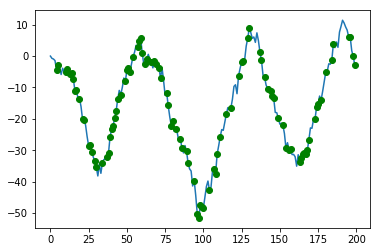

In [8]:
data = np.load("../datasets/process1a.npz")
ndata = 200
T = data['T'][:ndata]
Z = data['Z'][:ndata]
plt.plot(T,Z)
T = T.astype(float)
Z = Z.astype(float)
#Most basic testing for GPs

def split_data(T,Z,p=0.5):
    ind_list = np.arange(ndata,dtype=int)
    inds_training = np.random.choice(ind_list,size=int(ndata*(1-p)),
                                     replace=False)
                                    
    inds_test = [i for i in ind_list if i not in inds_training]
    xtrain = T[inds_training].reshape(-1,1)
    ytrain = Z[inds_training].reshape(-1,1)
    xtest = T[inds_test].reshape(-1,1)
    ytest = T[inds_test].reshape(-1,1)
    return xtrain,ytrain,xtest,ytest
    
xtrain,ytrain,xtest,ytest = split_data(T,Z)
plt.plot(xtrain,ytrain,'go')
plt.show()

In [9]:
kernel = kernels.Constant()*kernels.IsoMatern32(dim=1)
noisekernel = kernels.IIDNoiseKernel()
h2,l,sigma2 = 10.0,20.0,1e-3
hparams = [h2,l,sigma2]
positives = [True,True,True]
gp = gpobject.GPObject(kernel,noisekernel,hparams,(xtrain,ytrain))
old_time = time.clock()
gp = gp.optimize(positives)
new_time = time.clock()
print(new_time - old_time)
print([p.item() for p in gp.hparams])

0.364668
[524.1198120117188, 26.22307586669922, 1.979337215423584]


In [10]:
gpykern = GPy.kern.Matern32(input_dim=1,lengthscale=l,variance=h2)
gpymodel = GPy.models.GPRegression(xtrain,ytrain,gpykern,noise_var=sigma2)
old_time = time.clock()
gpymodel.optimize()
new_time = time.clock()
print(new_time - old_time)
print(gpymodel)

0.924188

Name : GP regression
Objective : 249.942128933
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  Mat32.variance           |   522.9160495921676  |      +ve      |        
  Mat32.lengthscale        |  26.201635522149605  |      +ve      |        
  Gaussian_noise.variance  |  1.9793428900998815  |      +ve      |        


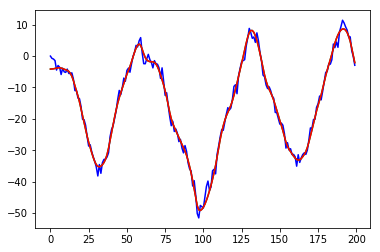

In [11]:
Zpred = []
Zpredgpy = []
for t in T:
    zpred = gp.predict([[np.float(t)]])[0].numpy()[0,0]
    Zpred.append(zpred)
    Zpredgpy.append(gpymodel.predict(np.array([[t]]))[0][0][0])
plt.figure()
plt.plot(T,Z,'b')
plt.plot(T,Zpredgpy,'g')
plt.plot(T,Zpred,'r')

-0.7233606973223914

 /usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


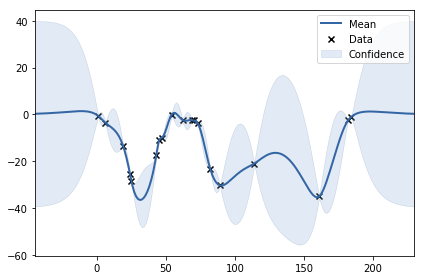

In [7]:
gpymodel.plot()
gpymodel.predict(np.array([[1.0]]))[0][0][0]